# DERMNET image clustering with DINOv2 embeddings
Authors
- [Igor Kołodziej](https://github.com/IgorKolodziej)
- [Kamil Eliaszuk](https://github.com/kamil5555579)

## Introduction
Welcome to our image clustering project, where we leverage the power of DINOv2 embeddings and advanced clustering techniques to group similar images effectively. This project explores various steps, including feature extraction, dimensionality reduction, duplicates removal, and clustering optimization, to achieve meaningful and accurate image clusters. 

In [2]:
import warnings
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

## Load dataset

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

dataset_path = 'train'
dataset = ImageFolder(root=dataset_path, transform=transform)

## Duplicates removal
Duplicate images can distort the clustering results by introducing bias and reducing the diversity of the dataset. To address this, we employ a hashing technique using the SHA-256 algorithm via the hashlib library. By converting each image into a hash value, we can efficiently identify and remove duplicates. This preprocessing step ensures that our dataset is unique and diverse, setting a solid foundation for the subsequent feature extraction and clustering processes. The function hash_image generates a unique hash for each image, allowing us to detect and eliminate duplicates accurately. This step is essential for enhancing the reliability and quality of our clustering results.



In [4]:
import hashlib

def hash_image(image):
    return hashlib.sha256(image.numpy()).hexdigest()

unique_images = {}
duplicates = []

for i, (image, _) in enumerate(dataset):
    image_hash = hash_image(image)
    
    if image_hash in unique_images:
        duplicates.append(i)
    else:
        unique_images[image_hash] = i
        
print(f"Number of duplicates: {len(duplicates)}")

Number of duplicates: 664


In [5]:
from torch.utils.data import Subset

indices = [i for i in range(len(dataset)) if i not in duplicates]
dataset = Subset(dataset, indices)

print(f"Dataset without duplicates size: {len(dataset)}")

Dataset without duplicates size: 14893


In [6]:
len(dataset) == len(unique_images)

True

## Feature extraction
We utilize the DINOv2 model for feature extraction due to its state-of-the-art performance in generating high-quality image embeddings. DINOv2 leverages self-supervised learning with vision transformers to produce rich and discriminative features, which are essential for effective clustering. By harnessing DINOv2 embeddings, we aim to achieve superior clustering results, capturing the intricate visual patterns and structures within the images, thus facilitating more accurate and meaningful grouping of similar images.

In [6]:
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /home/igor/.cache/torch/hub/facebookresearch_dinov2_main


In [7]:
dataloader = DataLoader(dataset, batch_size=256)

embeddings = []

with torch.no_grad():
    for images, _ in tqdm(dataloader):
        embedding = dinov2_vitb14(images)
        embeddings.append(embedding)
    
embeddings = torch.cat(embeddings, dim=0)
print(f"Embeddings matrix shape: {embeddings.shape}")

100%|██████████| 59/59 [51:16<00:00, 52.14s/it]


Embeddings matrix shape: torch.Size([14893, 768])


In [8]:
embeddings = embeddings.numpy()
np.save('embeddings_dino_base.npy', embeddings)

## Dimensionality reduction
We experiment with reducing the dimensionality of the extracted embeddings using PCA (Principal Component Analysis) and UMAP (Uniform Manifold Approximation and Projection) algorithms. Dimensionality reduction is crucial for visualizing high-dimensional data and enhancing the efficiency of subsequent clustering algorithms. PCA, a linear technique, reduces dimensions by projecting data onto the directions of maximum variance, preserving global structures. In contrast, UMAP, a non-linear method, focuses on maintaining the local neighborhood relationships, providing a more meaningful representation of the data's intrinsic geometry. By comparing PCA and UMAP, we aim to identify the most effective technique for retaining essential image features while reducing complexity, ultimately improving the clustering performance.

In [7]:
embeddings = np.load('embeddings_dino_base.npy')
print(f"Embeddings shape: {embeddings.shape}")

Embeddings shape: (14893, 768)


In [8]:
print(f"No duplicates among embeddings: {len(np.unique(embeddings, axis=0)) == len(embeddings)}")

No duplicates among embeddings: True


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

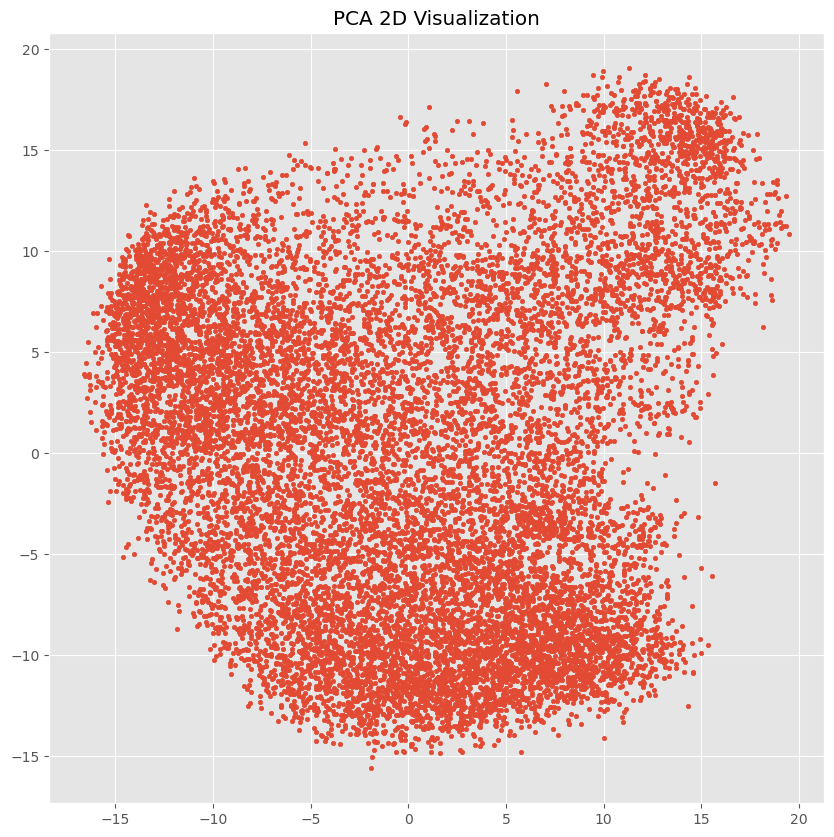

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], s=10)
plt.title('PCA 2D Visualization')
plt.show()

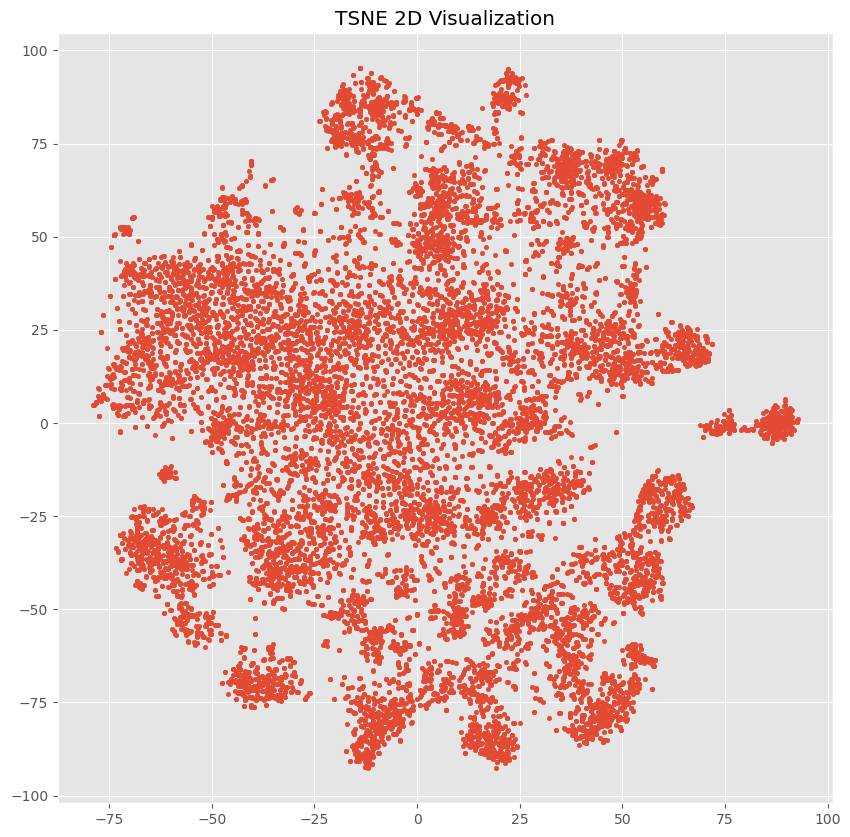

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
reduced_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], s=10)
plt.title('TSNE 2D Visualization')
plt.show()

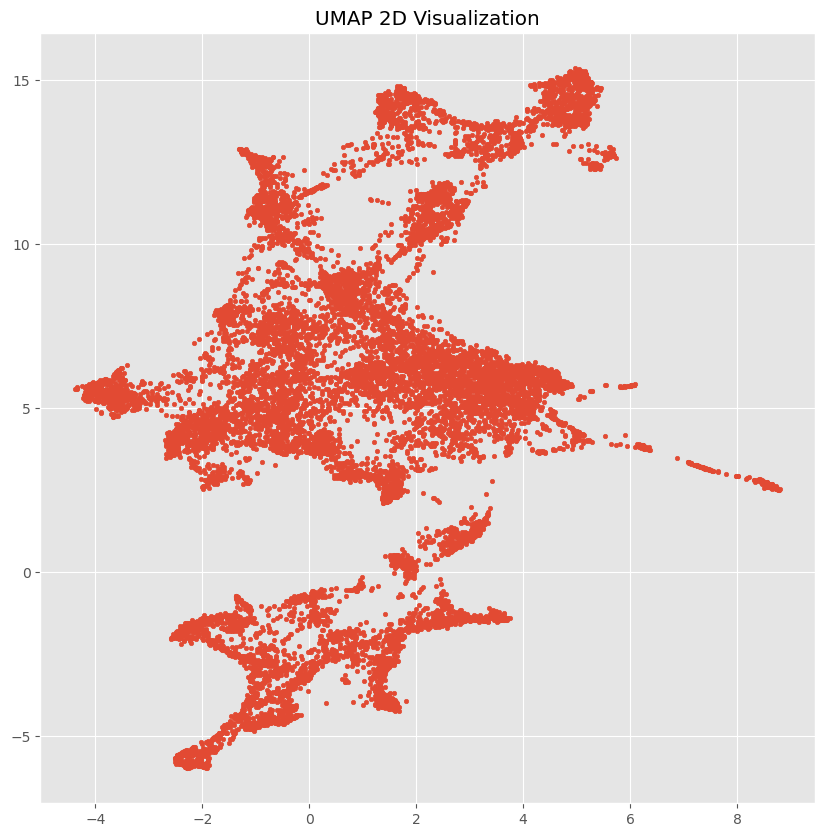

In [11]:
from umap import UMAP

reducer = UMAP(n_components=2, random_state=42)
reduced = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], s=10)
plt.title('UMAP 2D Visualization')
plt.show()

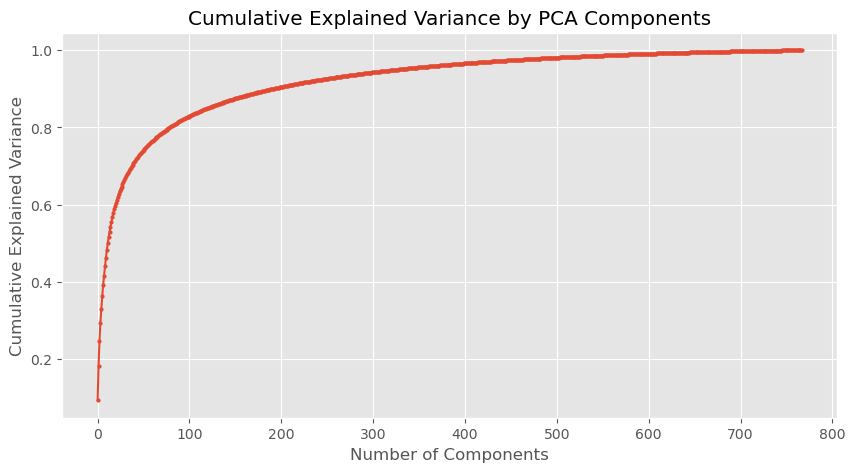

In [12]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(embeddings)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o', markersize=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [13]:
variance_threshold = 0.90
components_for_threshold = np.where(cumulative_variance >= variance_threshold)[0][0] + 1

print(f"Number of components needed to explain {variance_threshold*100}% of variance: {components_for_threshold}")

Number of components needed to explain 90.0% of variance: 192


In [11]:
n_components = 200

pca_reducer = PCA(n_components=n_components)
pca_features = pca_reducer.fit_transform(embeddings)

print(f"PCA reduced features shape: {pca_features.shape}")

PCA reduced features shape: (14893, 200)


#### Optimal number of UMAP components
We investigate the ideal number of components for UMAP by evaluating its impact on clustering performance using KMeans and OPTICS algorithms. We systematically vary the n_components parameter in UMAP and assess the quality of the resulting embeddings by applying KMeans and OPTICS clustering. For each configuration, we compute clustering metrics such as the Silhouette score, Calinski-Harabasz index, and Davies-Bouldin index to gauge the effectiveness of the reduced dimensions. This experimental approach allows us to identify the optimal number of UMAP components that balance dimensionality reduction with the preservation of essential data structure, thereby enhancing the overall clustering accuracy and interpretability. By fine-tuning n_components, we aim to achieve superior clustering results, leveraging UMAP's capacity to maintain local and global data structures.

In [15]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def calculate_metrics(features, cluster_labels):
    silhouette = silhouette_score(features, cluster_labels) 
    dbi = davies_bouldin_score(features, cluster_labels)
    ch = calinski_harabasz_score(features, cluster_labels)
    
    return silhouette, dbi, ch

def clustering_report(features, cluster_labels):
    silhouette, dbi, ch = calculate_metrics(features, cluster_labels)
    
    print(f"Number of clusters: {len(np.unique(cluster_labels))}")
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Index: {dbi}")
    print(f"Calinski-Harabasz Index: {ch}")

In [20]:
from sklearn.cluster import KMeans

n_components = [50, 100, 200, 300, 400, 500]

scaler = StandardScaler()

for n in n_components:
    umap_reducer = UMAP(n_components=n, random_state=42)
    umap_features = umap_reducer.fit_transform(embeddings)
    
    umap_features = scaler.fit_transform(umap_features)
    
    kmeans = KMeans(n_clusters=13, random_state=42, init='k-means++')
    cluster_labels = kmeans.fit_predict(umap_features)
    
    print(f"K-means clustering UMAP features with {n} components:")
    clustering_report(umap_features, cluster_labels)
    print()

K-means clustering UMAP features with 50 components:
Number of clusters: 13
Silhouette Score: 0.3313922584056854
Davies-Bouldin Index: 1.0307282740470334
Calinski-Harabasz Index: 4741.096281455653
K-means clustering UMAP features with 100 components:
Number of clusters: 13
Silhouette Score: 0.35521265864372253
Davies-Bouldin Index: 0.9899421067690504
Calinski-Harabasz Index: 4083.831916047887
K-means clustering UMAP features with 200 components:
Number of clusters: 13
Silhouette Score: 0.35707709193229675
Davies-Bouldin Index: 0.9717194035255085
Calinski-Harabasz Index: 4008.2497376515807
K-means clustering UMAP features with 300 components:
Number of clusters: 13
Silhouette Score: 0.3302958905696869
Davies-Bouldin Index: 0.9683459104989686
Calinski-Harabasz Index: 3904.7124673529943
K-means clustering UMAP features with 400 components:
Number of clusters: 13
Silhouette Score: 0.32939666509628296
Davies-Bouldin Index: 0.9895915319073243
Calinski-Harabasz Index: 4393.316987676659
K-mean

In [21]:
from sklearn.cluster import OPTICS

scaler = StandardScaler()

for n in n_components:
    umap_reducer = UMAP(n_components=n, random_state=42)
    umap_features = umap_reducer.fit_transform(embeddings)
    
    umap_features = scaler.fit_transform(umap_features)
    
    optics = OPTICS(min_samples=200)
    cluster_labels = optics.fit_predict(umap_features)
    
    print(f"OPTICS clustering UMAP features with {n} components:")
    clustering_report(umap_features, cluster_labels) if np.unique(cluster_labels).shape[0] > 1 else print("Only one cluster")
    print()

OPTICS clustering UMAP features with 50 components:
Number of clusters: 4
Silhouette Score: 0.005456175189465284
Davies-Bouldin Index: 0.9863816527782636
Calinski-Harabasz Index: 553.7514949430463
OPTICS clustering UMAP features with 100 components:
Number of clusters: 3
Silhouette Score: -0.03667581081390381
Davies-Bouldin Index: 1.146161587049133
Calinski-Harabasz Index: 435.574722399811
OPTICS clustering UMAP features with 200 components:
Number of clusters: 4
Silhouette Score: -0.02867027185857296
Davies-Bouldin Index: 1.0551394946930737
Calinski-Harabasz Index: 463.37059483964845
OPTICS clustering UMAP features with 300 components:
Number of clusters: 3
Silhouette Score: 0.0039281961508095264
Davies-Bouldin Index: 1.0956331601479325
Calinski-Harabasz Index: 499.11172120722705
OPTICS clustering UMAP features with 400 components:
Number of clusters: 3
Silhouette Score: -0.029686573892831802
Davies-Bouldin Index: 1.1571329568320556
Calinski-Harabasz Index: 449.2445538405455
OPTICS cl

In [13]:
n_components = 100

umap_reducer = UMAP(n_components=n_components, random_state=42)
umap_features = umap_reducer.fit_transform(embeddings)

print(f"UMAP reduced features shape: {umap_features.shape}")

UMAP reduced features shape: (14893, 100)


In [14]:
scaler = StandardScaler()

pca_features, umap_features = scaler.fit_transform(pca_features), scaler.fit_transform(umap_features)

## Clustering

In [14]:
def plot_metrics(param_range, silhouette_scores, dbi_scores, ch_scores, param_name):
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(param_range, silhouette_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score by {param_name}')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(param_range, dbi_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Davies-Bouldin Index')
    plt.title(f'Davies-Bouldin Index by {param_name}')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(param_range, ch_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Calinski-Harabasz Index')
    plt.title(f'Calinski-Harabasz Index by {param_name}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [15]:
def plot_clusters(cluster_labels, dataset):
    clusters = np.unique(cluster_labels)
    
    for cluster in clusters:
        indices = np.where(cluster_labels == cluster)[0]
        indices = indices[:5]
        
        plt.figure(figsize=(15, 5))
        for i, index in enumerate(indices):
            image, _ = dataset[index]
            image = image.permute(1, 2, 0).numpy()
            plt.subplot(1, 5, i+1)
            plt.imshow(image)
            plt.axis('off')
        
        plt.suptitle(f'Cluster {cluster}')
        plt.show()

In [16]:
def show_cluster(cluster_number, num_images=20):
    indices = np.where(kmeans_labels == cluster_number)[0]
    indices = indices[:num_images]

    plt.figure(figsize=(15, 5))
    for i, index in enumerate(indices):
        image, _ = dataset[index]
        image = image.permute(1, 2, 0).numpy()
        num_rows = num_images // 10
        plt.subplot(num_rows, 10, i+1)
        plt.imshow(image)
        plt.axis('off')
        
    plt.suptitle(f'Cluster {cluster_number}')
    plt.show()

### K-means

In [29]:
def inspect_kmeans(reduced_features, K_range=range(2, 24)):    
    inertias = []
    silhouette_scores = []
    dbi_scores = []
    ch_scores = []
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
        cluster_labels = kmeans.fit_predict(reduced_features)
        
        inertias.append(kmeans.inertia_)
        silhouette, dbi, ch = calculate_metrics(reduced_features, cluster_labels)
        silhouette_scores.append(silhouette)
        dbi_scores.append(dbi)
        ch_scores.append(ch)
    
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(K_range, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('WCSS')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(K_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(K_range, dbi_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(K_range, ch_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Index')
    plt.title('Calinski-Harabasz Index')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### UMAP vs PCA

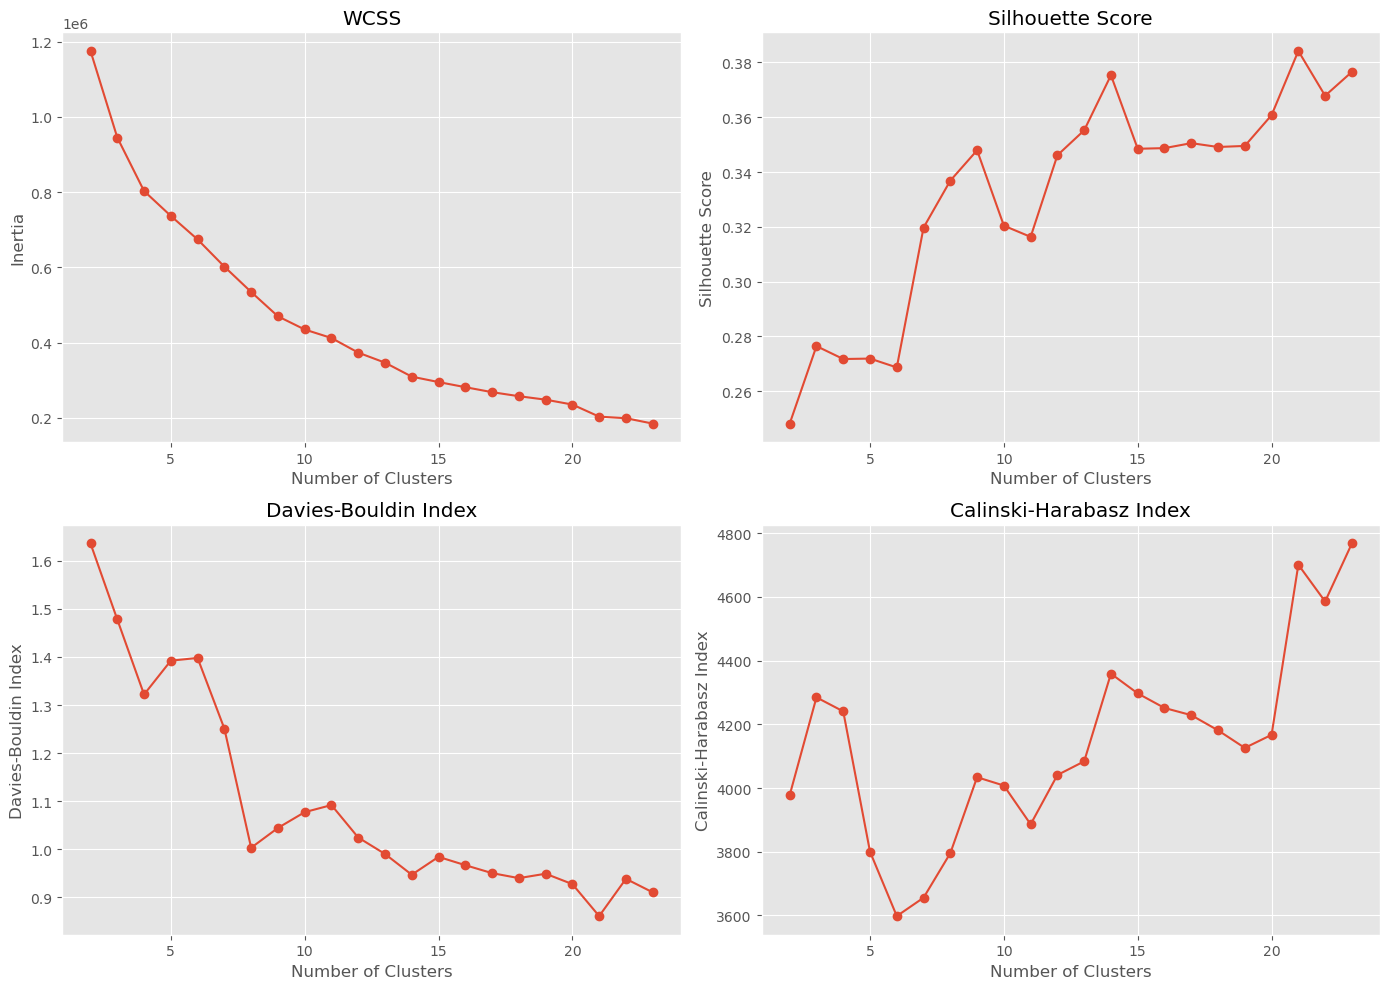

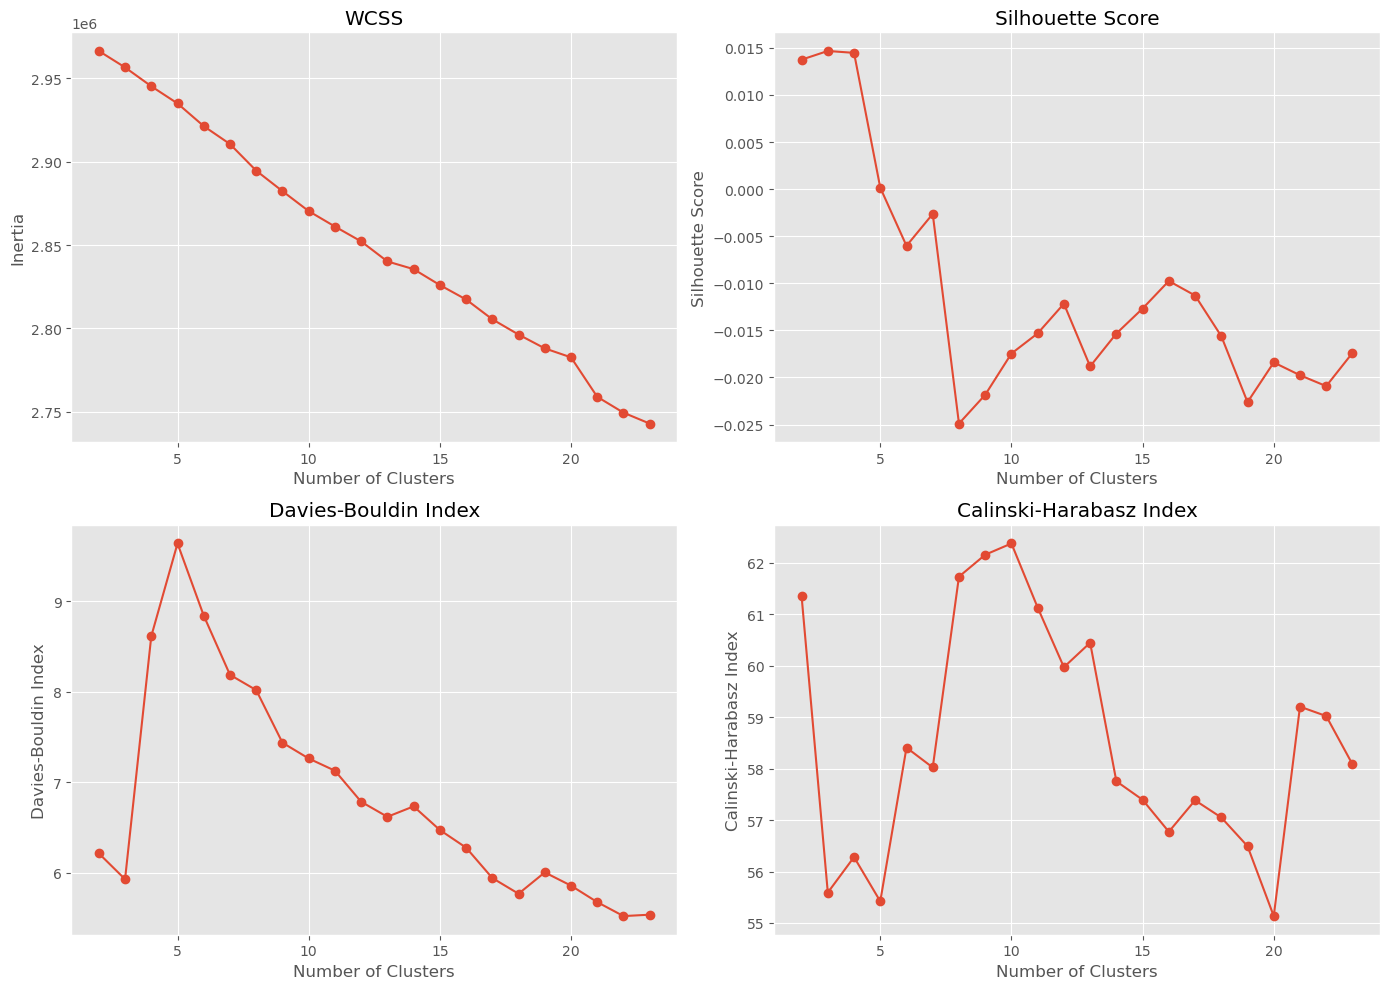

In [30]:
inspect_kmeans(umap_features)
inspect_kmeans(pca_features)

In [32]:
num_clusters = 14

kmeans = KMeans(n_clusters=num_clusters, random_state=42, init='k-means++')
kmeans_labels = kmeans.fit_predict(umap_features)

clustering_report(umap_features, kmeans_labels)

Number of clusters: 14
Silhouette Score: 0.37530967593193054
Davies-Bouldin Index: 0.9467073478181202
Calinski-Harabasz Index: 4359.050501730525


In [ ]:
plot_clusters(kmeans_labels, dataset)

In [34]:
cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
cluster_sizes.sort_values(ascending=False)

6     2583
0     2159
11    1667
4     1123
12    1106
2     1092
13     931
1      904
9      799
8      662
5      625
7      541
10     524
3      177
Name: count, dtype: int64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


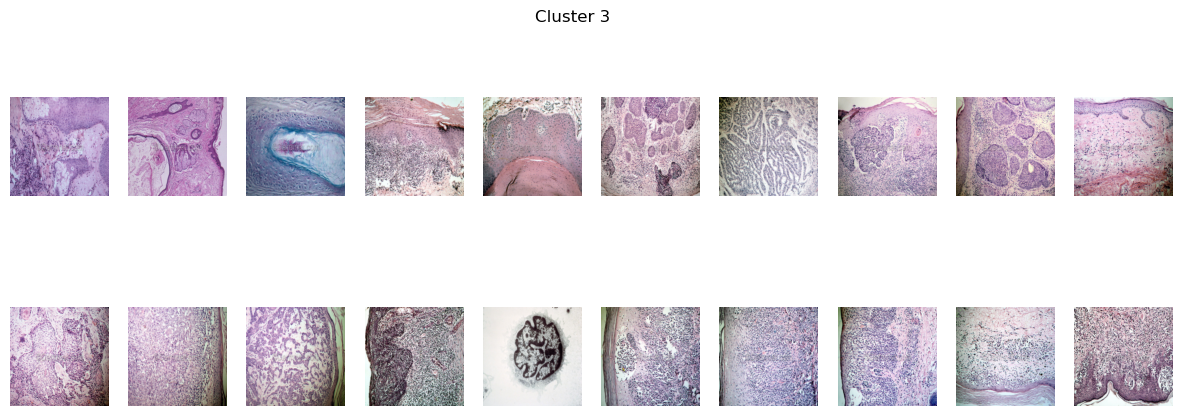

In [44]:
show_cluster(3)

### DBSCAN

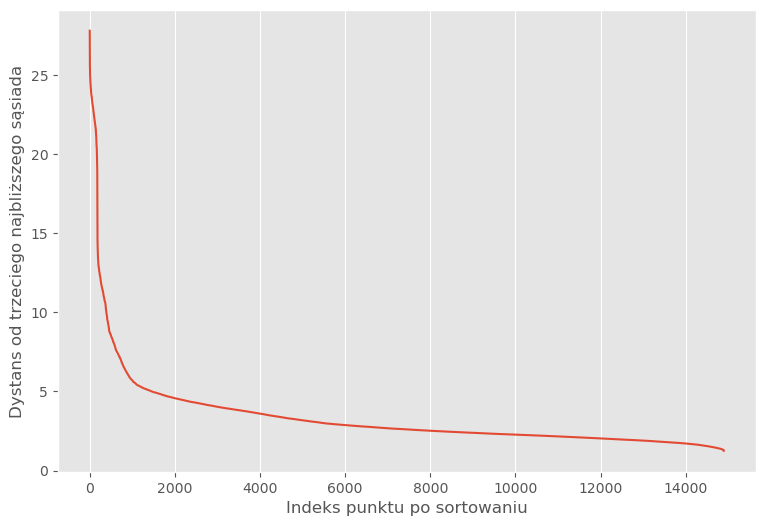

In [45]:
from sklearn.neighbors import NearestNeighbors

minPts = 200
nbrs = NearestNeighbors(n_neighbors=minPts).fit(umap_features)
distances, indices = nbrs.kneighbors(umap_features)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,umap_features.shape[0]+1)), distanceDec)

plt.title('K-distance plot with UMAP features')
plt.grid(axis='y')

plt.show()

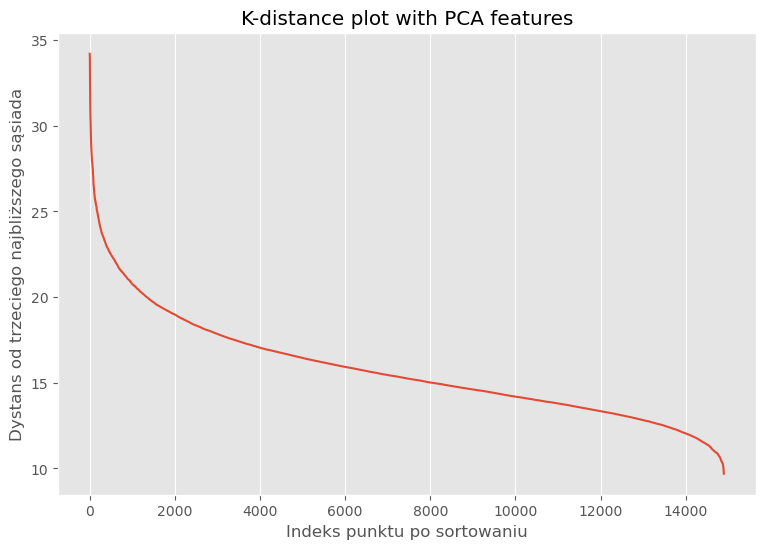

In [46]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

minPts = 200
nbrs = NearestNeighbors(n_neighbors=minPts).fit(pca_features)
distances, indices = nbrs.kneighbors(pca_features)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,pca_features.shape[0]+1)), distanceDec)

plt.title('K-distance plot with PCA features')
plt.grid(axis='y')

plt.show()

In [60]:
dbscan = DBSCAN(eps=15, min_samples=400)

dbscan_pca_labels = dbscan.fit_predict(pca_features)

clustering_report(pca_features, dbscan_pca_labels) if np.unique(dbscan_pca_labels).shape[0] > 1 else print("No clusters for PCA")

Number of clusters: 2
Silhouette Score: 0.12524738907814026
Davies-Bouldin Index: 16.275615593840445
Calinski-Harabasz Index: 48.37596067876126


In [61]:
dbscan = DBSCAN(eps=3, min_samples=200)

dbscan_umap_labels = dbscan.fit_predict(umap_features)

clustering_report(umap_features, dbscan_umap_labels) if np.unique(dbscan_umap_labels).shape[0] > 1 else print("No clusters for UMAP")

Number of clusters: 6
Silhouette Score: 0.1347815990447998
Davies-Bouldin Index: 1.5379217301016161
Calinski-Harabasz Index: 1365.4577787762703


In [64]:
pd.Series(dbscan_umap_labels).value_counts().sort_values(ascending=False)

 1    8557
-1    3034
 0    2240
 2     551
 3     310
 4     201
Name: count, dtype: int64

### HDBSCAN

In [69]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=100, min_samples=10)

hdbscan_umap_labels = hdbscan.fit_predict(umap_features)

clustering_report(umap_features, hdbscan_umap_labels) if np.unique(hdbscan_umap_labels).shape[0] > 1 else print("No clusters")

Number of clusters: 4
Silhouette Score: 0.2805403172969818
Davies-Bouldin Index: 2.48762460440802
Calinski-Harabasz Index: 455.60798608700634


### OPTICS

In [73]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=150)

optics_umap_labels = optics.fit_predict(umap_features)

clustering_report(umap_features, optics_umap_labels) if np.unique(optics_umap_labels).shape[0] > 1 else print("Only one cluster")

Number of clusters: 6
Silhouette Score: 0.0206608846783638
Davies-Bouldin Index: 0.9341751162358993
Calinski-Harabasz Index: 627.9057262911954


### Agglomerative clustering

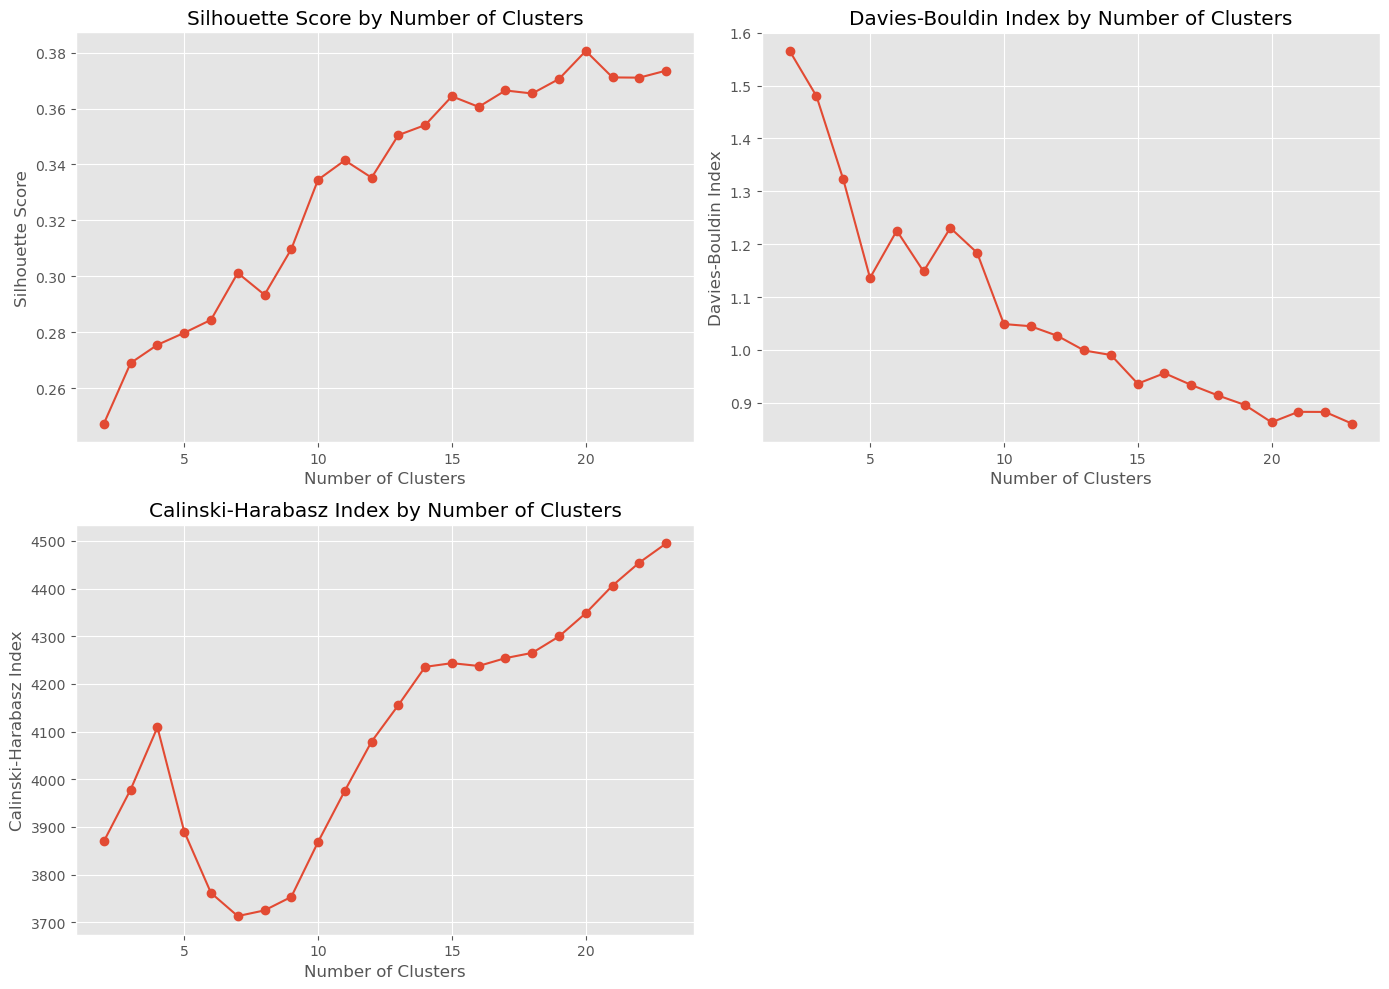

In [72]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = range(2, 24)

silhouette_scores = []
dbi_scores = []
ch_scores = []

for n in num_clusters:
    agglomerative = AgglomerativeClustering(n_clusters=n)
    cluster_labels = agglomerative.fit_predict(umap_features)
    
    silhouette, dbi, ch = calculate_metrics(umap_features, cluster_labels)
    silhouette_scores.append(silhouette)
    dbi_scores.append(dbi)
    ch_scores.append(ch)
    
plot_metrics(num_clusters, silhouette_scores, dbi_scores, ch_scores, 'Number of Clusters')

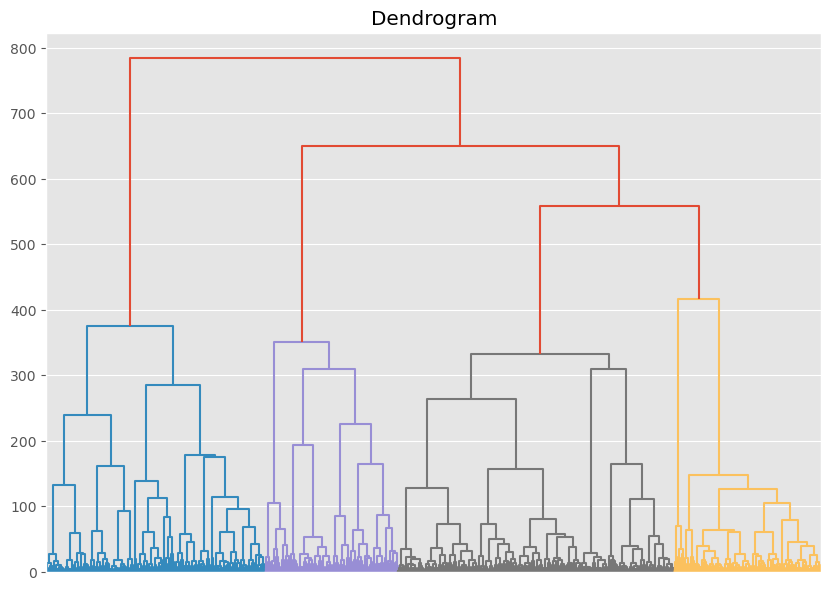

In [24]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(umap_features, method='ward'))
plt.xticks([])
plt.show()

In [22]:
silhuette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
index = []

for metric in ['euclidean', 'manhattan', 'cosine']:
    for linkage in ['complete', 'average', 'single']:
        agglomerative = AgglomerativeClustering(n_clusters=15, metric=metric, linkage=linkage)
        labels = agglomerative.fit_predict(umap_features)
        silhuette_scores.append(silhouette_score(umap_features, labels))
        calinski_harabasz_scores.append(calinski_harabasz_score(umap_features, labels))
        davies_bouldin_scores.append(davies_bouldin_score(umap_features, labels))
        index.append(f'{metric}_{linkage}')
        
agglomerative = AgglomerativeClustering(n_clusters=15, metric='euclidean', linkage='ward')
labels = agglomerative.fit_predict(umap_features)
silhuette_scores.append(silhouette_score(umap_features, labels))
calinski_harabasz_scores.append(calinski_harabasz_score(umap_features, labels))
davies_bouldin_scores.append(davies_bouldin_score(umap_features, labels))
index.append('euclidean_ward')

scores = pd.DataFrame({'silhouette': silhuette_scores, 'calinski_harabasz': calinski_harabasz_scores, 'davies_bouldin': davies_bouldin_scores}, index=index)
scores  

,silhouette,calinski_harabasz,davies_bouldin
euclidean_complete,0.295482,2550.780531,1.098781
euclidean_average,0.267369,1672.610905,0.800148
euclidean_single,0.194301,68.270781,0.524534
manhattan_complete,0.289510,2466.382599,1.066259
manhattan_average,0.283521,2147.342642,0.797698
manhattan_single,0.134930,67.636019,0.547574
cosine_complete,0.185531,2287.022110,1.542946
cosine_average,0.254455,3265.117321,0.926762
cosine_single,-0.445488,66.832117,2.126445
euclidean_ward,0.364376,4243.712612,0.936109


In [23]:
num_clusters = 15

agglomerative = AgglomerativeClustering(n_clusters=num_clusters)

agglomerative_umap_labels = agglomerative.fit_predict(umap_features)

clustering_report(umap_features, agglomerative_umap_labels)

Number of clusters: 15
Silhouette Score: 0.3643762767314911
Davies-Bouldin Index: 0.9361093460801231
Calinski-Harabasz Index: 4243.712612021818


In [23]:
pd.Series(agglomerative_umap_labels).value_counts().sort_values(ascending=False)

7     2645
5     1978
0     1743
11    1534
2     1275
1      911
3      863
12     820
4      791
8      654
9      522
6      486
13     353
10     177
14     141
Name: count, dtype: int64

In [27]:
df = pd.DataFrame(agglomerative_umap_labels, columns=['cluster'])
df.to_csv('cluster_labels.csv', index=False)

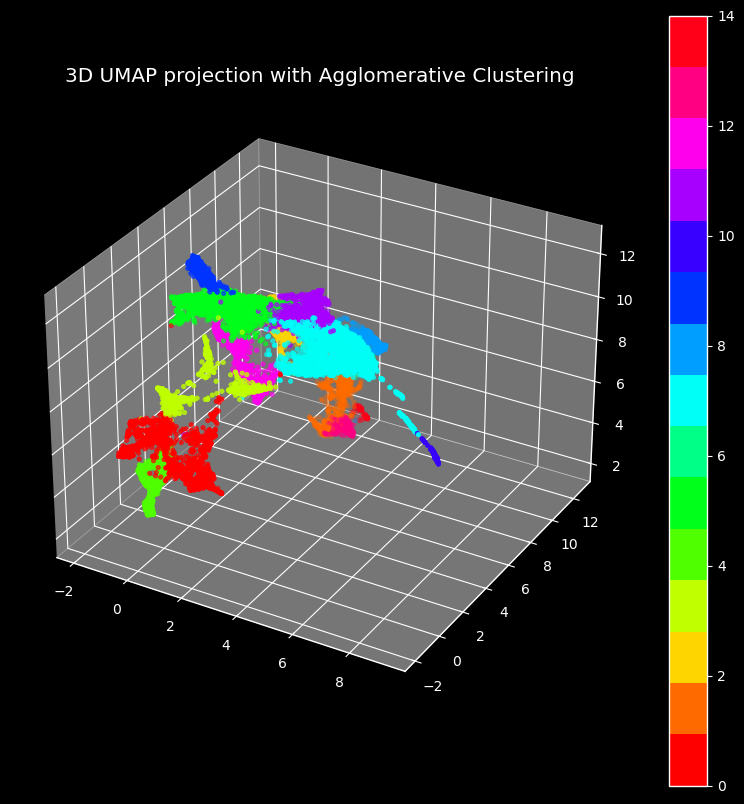

In [48]:
from matplotlib.colors import ListedColormap

num_colors = 15
colors = plt.cm.hsv(np.linspace(0, 1, num_colors))
cmap = ListedColormap(colors)

reducer = UMAP(n_components=3, random_state=42)
reduced = reducer.fit_transform(embeddings)

df = pd.DataFrame(reduced, columns=['x', 'y', 'z'])
df['label'] = agglomerative_umap_labels

with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(df['x'], df['y'], df['z'], c=df['label'], cmap=cmap, s=10)
    plt.colorbar(scatter)
    plt.title('3D UMAP projection with Agglomerative Clustering')
    plt.savefig('3d_clusters_projection.png')
    plt.show()

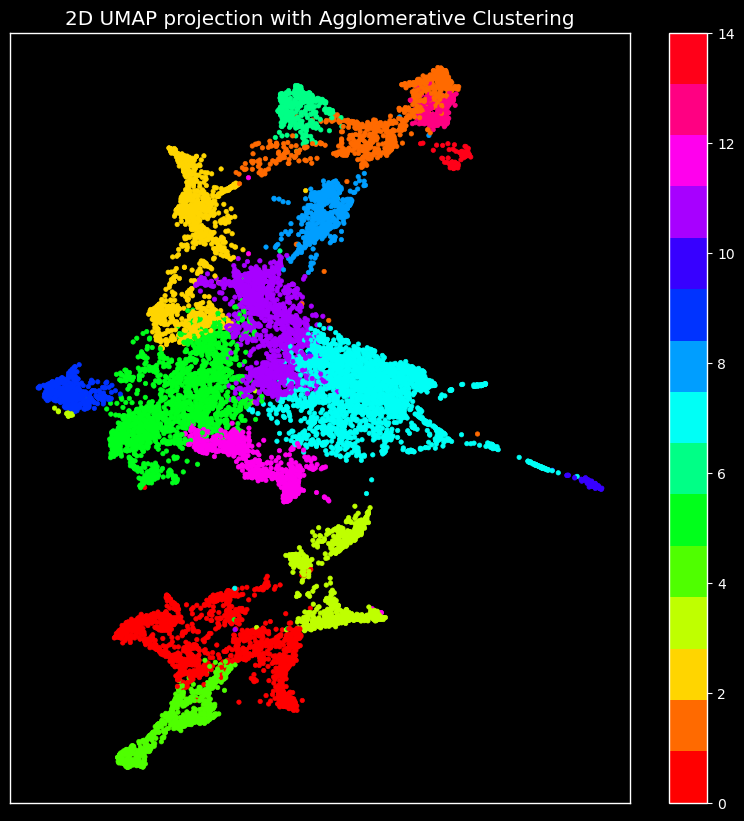

In [47]:
reducer = UMAP(n_components=2, random_state=42)
reduced = reducer.fit_transform(embeddings)

df = pd.DataFrame(reduced, columns=['x', 'y'])
df['label'] = agglomerative_umap_labels

with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(10, 10))

    scatter = plt.scatter(df['x'], df['y'], c=df['label'], cmap=cmap, s=10)
    plt.colorbar(scatter)
    plt.title('2D UMAP projection with Agglomerative Clustering')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.savefig('2d_clusters_projection.png')
    plt.show()

In [ ]:
plot_clusters(agglomerative_umap_labels, dataset)

## Final model
For the final choice of the clustering algorithm we consider both KMeans and Agglomerative Clustering. Through extensive experimentation, we found that KMeans slightly outperforms Agglomerative Clustering in terms of various metrics such as the Silhouette score, Calinski-Harabasz index, and Davies-Bouldin index. However, we ultimately choose Agglomerative Clustering for its robustness and flexibility. Unlike KMeans, which assumes spherical clusters and requires the number of clusters to be predefined, Agglomerative Clustering does not make such assumptions and can handle clusters of arbitrary shapes. Additionally, Agglomerative Clustering provides a hierarchical clustering tree, which offers valuable insights into the data's structure and allows for more intuitive decision-making regarding the optimal number of clusters. This hierarchical approach aligns better with the diverse and complex nature of our image dataset, making Agglomerative Clustering the preferred choice for our final model.